In [1]:
import pandas as pd
import numpy as np
import os
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from matplotlib import pyplot as plt
from sklearn.manifold import TSNE
import seaborn as sns
from sklearn.cluster import KMeans,DBSCAN
from scipy import stats
from sklearn import neighbors
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import label_binarize
from sklearn import svm

In [ ]:
!wget https://cf.10xgenomics.com/samples/cell-vdj/3.0.2/vdj_v1_hs_aggregated_donor2/vdj_v1_hs_aggregated_donor2_filtered_feature_bc_matrix.tar.gz -P data/10x_donor2/


--2023-07-05 10:00:36--  https://cf.10xgenomics.com/samples/cell-vdj/3.0.2/vdj_v1_hs_aggregated_donor3/vdj_v1_hs_aggregated_donor3_filtered_feature_bc_matrix.tar.gz
Resolving cf.10xgenomics.com (cf.10xgenomics.com)... 188.114.99.236, 188.114.98.236, 2a06:98c1:3123:e000::c, ...
Connecting to cf.10xgenomics.com (cf.10xgenomics.com)|188.114.99.236|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 270871692 (258M) [application/x-tar]
Saving to: ‘data/10x_donor3/vdj_v1_hs_aggregated_donor3_filtered_feature_bc_matrix.tar.gz’

 vdj_v1_hs_aggregat  81%[===============>    ] 209.30M   281KB/s    eta 66s    

In [ ]:
!wget https://cf.10xgenomics.com/samples/cell-vdj/3.0.2/vdj_v1_hs_aggregated_donor2/vdj_v1_hs_aggregated_donor3_all_contig_annotations.csv -P data/10x_donor3/

In [ ]:
!gunzip data/10x_donor2/vdj_v1_hs_aggregated_donor2_filtered_feature_bc_matrix.tar.gz

In [ ]:
!tar -xvf data/10x_donor2/vdj_v1_hs_aggregated_donor2_filtered_feature_bc_matrix.tar -C data/10x_donor2/

In [ ]:
!gunzip data/10x_donor2/filtered_feature_bc_matrix/matrix.mtx.gz
!gunzip data/10x_donor2/filtered_feature_bc_matrix/features.tsv.gz
!gunzip data/10x_donor2/filtered_feature_bc_matrix/barcodes.tsv.gz

In [2]:
import tcr_emb_code
import data_processing

In [3]:
barcodes = data_processing.read_barcodes('data/10x_donor2/filtered_feature_bc_matrix/barcodes.tsv')

features = data_processing.read_features('data/10x_donor2/filtered_feature_bc_matrix/features.tsv')

matrix = data_processing.read_matrix('data/10x_donor2/filtered_feature_bc_matrix/matrix.mtx')

matrix_2 = data_processing.merge_matrix(matrix,barcodes,features)
matrix_2 = data_processing.get_value_matrix(matrix_2)

matrix_3 = matrix_2[matrix_2['type']=='Antibody Capture']
matrix_3 = matrix_3[matrix_3['value_type']!='TotalSeqC']

matrix_t = data_processing.get_tetramer_matrix(matrix_3)
matrix_t


,barcode,value,tetramer,count
0,TTTGTCATCGTCACGG-40,AAKGRGAAL,AAKGRGAAL,130393735
1,TTTGTCATCGTCACGG-40,AVFDRKSDAK,AAKGRGAAL,3
2,TTTGTCATCGTCACGG-40,AYSSAGASI,AAKGRGAAL,1
3,TTTGTCATCGTCACGG-40,KLGGALQAK,AAKGRGAAL,1
4,TTTGTCATCGTCACGG-40,QPRAPIRPI,AAKGRGAAL,1
...,...,...,...,...
405125,GGAACTTCAGGCAGTA-4,RLRAEAQVK,RLRAEAQVK,6
405126,GGAACTTCAGGCAGTA-4,KLGGALQAK,RLRAEAQVK,5
405127,GGAACTTCAGGCAGTA-4,AVFDRKSDAK,RLRAEAQVK,4
405128,GGAACTTCAGGCAGTA-4,QYDPVAALF,RLRAEAQVK,2


In [4]:
barcode_tetramer = data_processing.get_barcode_tetramer(matrix_3)
barcode_tetramer

/home/yuliajk/projects/tcr_emb/data_processing.py:67: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tetramers['tetramer'] = tetramers['value']


,barcode,tetramer,count
0,TTTGTCATCGTCACGG-40,AAKGRGAAL,130393735
70742376,GTAACGTAGCGTGAGT-39,GILGFVFTL,14899
101200383,AAGGCAGCATCAGTAC-4,RAKFKQLL,5388
51546305,GCGCAACCAGTGGGAT-37,AVFDRKSDAK,1165
51544919,TCTATTGTCGATGAGG-36,AVFDRKSDAK,948
...,...,...,...
101176045,CACATAGCATCTATGG-9,RIAAWMATY,1
101175951,ACACCCTTCTATCGCC-9,RIAAWMATY,1
101174597,GCATACAGTTCTGGTA-6,RIAAWMATY,1
101174430,CACACCTGTAGCCTCG-6,RIAAWMATY,1


In [5]:
data = pd.read_csv("data/10x_donor2/vdj_v1_hs_aggregated_donor2_all_contig_annotations.csv", sep = ',')
data_c_annot = data.copy()
data_c_annot = data_c_annot[data_c_annot['is_cell']==True].reset_index(drop=True)
data_c_annot = tcr_emb_code.filter_table(data_c_annot,'None')
data_c = data_c_annot.copy()
data_c = data_processing.merge_anot_matrix(data_c,barcode_tetramer)
data_c = data_c.drop_duplicates(['barcode','tetramer'])
data_c.to_csv('data_scripts/data_annot_preped.txt', sep='\t', index = False)
data_c

,barcode,is_cell,contig_id,high_confidence,length,chain,v_gene,d_gene,j_gene,c_gene,full_length,productive,cdr3,cdr3_nt,reads,umis,raw_clonotype_id,raw_consensus_id,tetramer,count
0,AAACCTGAGAAACCTA-30,True,AAACCTGAGAAACCTA-30_contig_1,True,690,TRB,TRBV12-3,None,TRBJ2-2,TRBC2,True,True,CASSFSGNTGELFF,TGTGCCAGCAGTTTTAGCGGGAACACCGGGGAGCTGTTTTTT,28665,26,clonotype1,clonotype1_consensus_2,RAKFKQLL,61
2,AAACCTGAGAACTCGG-39,True,AAACCTGAGAACTCGG-39_contig_1,True,711,TRB,TRBV6-6,TRBD2,TRBJ2-3,TRBC2,True,True,CASSPAGGTDTQYF,TGTGCCAGCAGCCCCGCGGGGGGCACAGATACGCAGTATTTT,11830,8,clonotype149,clonotype149_consensus_2,KLGGALQAK,3
4,AAACCTGAGAAGGGTA-9,True,AAACCTGAGAAGGGTA-9_contig_1,True,696,TRB,TRBV27,TRBD1,TRBJ2-2,TRBC2,True,True,CASSPHFQVDTGELFF,TGTGCCAGCAGTCCTCATTTTCAGGTGGACACCGGGGAGCTGTTTTTT,10729,9,clonotype60,clonotype60_consensus_1,RAKFKQLL,20
6,AAACCTGAGACACTAA-40,True,AAACCTGAGACACTAA-40_contig_1,True,661,TRB,TRBV4-1,TRBD1,TRBJ1-3,TRBC1,True,True,CASSPFWTDGNTIYF,TGCGCCAGCAGCCCTTTTTGGACAGATGGAAACACCATATATTTT,8488,7,clonotype3981,clonotype3981_consensus_1,LLDFVRFMGV,1
8,AAACCTGAGACGCTTT-11,True,AAACCTGAGACGCTTT-11_contig_1,True,685,TRB,TRBV12-3,None,TRBJ2-2,TRBC2,True,True,CASSFSGNTGELFF,TGTGCCAGCAGTTTTAGCGGGAACACCGGGGAGCTGTTTTTT,28273,10,clonotype1,clonotype1_consensus_2,RAKFKQLL,79
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
146505,TTTGTCATCTGCGTAA-36,True,TTTGTCATCTGCGTAA-36_contig_1,True,693,TRB,TRBV29-1,TRBD2,TRBJ1-1,TRBC1,True,True,CSDWEGGSTEAFF,TGCAGCGATTGGGAGGGAGGGAGCACTGAAGCTTTCTTT,24442,14,clonotype20652,clonotype20652_consensus_1,AVFDRKSDAK,11
146507,TTTGTCATCTGGCGTG-9,True,TTTGTCATCTGGCGTG-9_contig_1,True,530,TRA,TRAV13-1,None,TRAJ50,TRAC,True,True,CAAAETSYDKVIF,TGTGCAGCAGCGGAAACCTCCTACGACAAGGTGATATTT,13409,7,clonotype778,clonotype778_consensus_1,RAKFKQLL,10
146508,TTTGTCATCTGGTGTA-23,True,TTTGTCATCTGGTGTA-23_contig_1,True,854,TRB,TRBV11-3,TRBD1,TRBJ2-2,TRBC2,True,True,CASQGPNTGELFF,TGTGCCAGCCAGGGGCCGAACACCGGGGAGCTGTTTTTT,41938,14,clonotype20653,clonotype20653_consensus_2,RAKFKQLL,2
146510,TTTGTCATCTTGAGAC-35,True,TTTGTCATCTTGAGAC-35_contig_1,True,491,TRA,TRAV13-1,None,TRAJ50,TRAC,True,True,CAASETSYDKVIF,TGTGCAGCAAGTGAAACCTCCTACGACAAGGTGATATTT,7009,2,clonotype1,clonotype1_consensus_1,RAKFKQLL,53


In [6]:
prototypes_path_tra = 'data_scripts/prototypes_tra_olga.txt'
prototypes_path_trb = 'data_scripts/prototypes_trb_olga.txt'

In [195]:
prototypes_path_tra_pre = pd.read_csv('/home/yuliajk/olga_wd/example_seqs_tra_072023.tsv',sep='\t')
prototypes_tra = tcr_emb_code.prototypes_prep(prototypes_path_tra_pre)
prototypes_tra.to_csv(prototypes_path_tra,sep='\t', index = False)

In [18]:
prototypes_path_trb_pre = pd.read_csv('/home/yuliajk/olga_wd/example_seqs_trb_072023.tsv',sep='\t')
prototypes_trb = tcr_emb_code.prototypes_prep(prototypes_path_trb_pre)
prototypes_trb.to_csv(prototypes_path_trb,sep='\t', index = False)

In [7]:
data_c = data_c[data_c['tetramer']!='KLGGALQAK'].reset_index(drop=True)

In [40]:
def data_filter_for_prototypes(data, prototypes_path):
    prototypes=pd.read_csv(prototypes_path, sep = '\t')
    data = data[data['v_gene'].isin(list(prototypes['v']))].reset_index(drop=True)
    data = data[data['j_gene'].isin(list(prototypes['j']))].reset_index(drop=True)
    return data

In [8]:
data_c_tra = data_c[data_c['chain']=='TRA']
data_c_tra = tcr_emb_code.data_filter_for_prototypes(data_c_tra,prototypes_path_tra)

In [9]:
data_c_trb = data_c[data_c['chain']=='TRB']
data_c_trb = tcr_emb_code.data_filter_for_prototypes(data_c_trb,prototypes_path_trb)

In [44]:
def mir_clac(data, file_path_prefix, file_date, chain, prototypes_path):
    data_c_mir = tcr_emb_prep.columns_prep(data)
    file_path = 'data_scripts/' + file_path_prefix + file_date +'.txt'
    data_c_mir.to_csv(file_path, sep='\t', index = False)
    
    mir_path = "mir-1.0-SNAPSHOT.jar"
    species = "Human"
    input_data_path = file_path
    output_path = 'data_scripts/' +file_path_prefix+ file_date
    
    command = "java -Xmx100G -cp " + mir_path + " com.antigenomics.mir.scripts.Examples cdr3aavj-pairwise-dist " + "-S " + species + " -G " + chain + " -F VDJtools " + "-I " + prototypes_path + " " + input_data_path + " -O " + output_path
    os.system(command)


In [18]:
def mir_dists_format(data_dists_raw, data):
    if len(data_dists_raw['id1'].drop_duplicates()) < len(data_dists_raw['id2'].drop_duplicates()):
        first_index = 'id1'
        second_index = 'id2'
    else:
        first_index = 'id2'
        second_index = 'id1'            
    data_dists_raw['cdr3_idx'] = 'cdr3_' + data_dists_raw[first_index].astype(str)
    data_dists_raw['v_idx'] = 'v_' + data_dists_raw[first_index].astype(str)
    data_dists_raw['j_idx'] = 'j_' + data_dists_raw[first_index].astype(str)
    data_dists_raw = pd.concat([data_dists_raw.pivot(index=second_index,columns='cdr3_idx',values='cdr3.score').reset_index(),
                     data_dists_raw.pivot(index=second_index,columns='v_idx',values='v.score').reset_index(),
                     data_dists_raw.pivot(index=second_index,columns='j_idx',values='j.score').reset_index()], axis=1)
    data_dists_raw = data_dists_raw.drop(second_index,axis=1)
    data_dists_raw = data_dists_raw.set_index(data['barcode'],drop = True)
    return data_dists_raw

In [216]:
tcr_emb_code.mir_clac(data_c_tra, '10x_d2_tra', '060723','TRA',prototypes_path_tra)

NameError: name 'tcr_emb_prep' is not defined

In [11]:
prefix_path = '10x_d2_trb'
date_path = '060723'

In [13]:
tcr_emb_code.mir_clac(data_c_trb, prefix_path, date_path,'TRB',prototypes_path_trb)

In [15]:
data_dists_raw_path = 'data_scripts/' + prefix_path + date_path + '.dist.txt'
data_dists_raw = pd.read_csv(data_dists_raw_path, sep = '\t')

In [19]:
data_c_b_dist = mir_dists_format(data_dists_raw, data_c_trb)
data_c_b_dist

,cdr3_1,cdr3_10,cdr3_100,cdr3_1000,cdr3_1001,cdr3_1002,cdr3_1003,cdr3_1004,cdr3_1005,cdr3_1006,...,j_990,j_991,j_992,j_993,j_994,j_995,j_996,j_997,j_998,j_999
barcode,,,,,,,,,,,,,,,,,,,,,
AAACCTGAGAAACCTA-30,19.0,18.0,23.0,7.0,35.0,12.0,16.0,6.0,16.0,25.0,...,45.0,44.0,51.0,42.0,42.0,38.0,38.0,49.0,43.0,43.0
AAACCTGAGAAGGGTA-9,20.0,17.0,11.0,10.0,15.0,4.0,20.0,7.0,19.0,21.0,...,45.0,44.0,51.0,42.0,42.0,38.0,38.0,49.0,43.0,43.0
AAACCTGAGACACTAA-40,18.0,23.0,6.0,9.0,14.0,5.0,24.0,11.0,19.0,23.0,...,41.0,32.0,38.0,35.0,35.0,29.0,29.0,35.0,87.0,87.0
AAACCTGAGACGCTTT-11,19.0,18.0,23.0,7.0,35.0,12.0,16.0,6.0,16.0,25.0,...,45.0,44.0,51.0,42.0,42.0,38.0,38.0,49.0,43.0,43.0
AAACCTGAGACTGGGT-33,24.0,24.0,25.0,23.0,32.0,15.0,23.0,20.0,16.0,11.0,...,60.0,35.0,47.0,81.0,81.0,42.0,42.0,62.0,35.0,35.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTTGTCATCGTCACGG-40,14.0,5.0,7.0,16.0,7.0,26.0,18.0,12.0,20.0,4.0,...,41.0,38.0,45.0,43.0,43.0,37.0,37.0,41.0,33.0,33.0
TTTGTCATCGTCTGAA-13,9.0,10.0,19.0,16.0,25.0,-6.0,14.0,5.0,7.0,9.0,...,62.0,44.0,51.0,62.0,62.0,44.0,44.0,85.0,35.0,35.0
TTTGTCATCTCAAGTG-14,12.0,10.0,28.0,13.0,24.0,7.0,22.0,13.0,10.0,12.0,...,44.0,45.0,76.0,47.0,47.0,39.0,39.0,51.0,38.0,38.0


In [205]:

#file_date = '060723'
#file_path = 'data_scripts/10x_d2_tra' + file_date +'.txt'
##data_c_mir.to_csv(file_path, sep='\t', index = False)

In [206]:

#mir_path = "mir-1.0-SNAPSHOT.jar"
#species = "Human"
#chain = 'TRA'
#prototypes_path = prototypes_path_tra
#input_data_path = 'data_scripts/10x_d2_tra060723.txt'
#output_path = "data_scripts/10x_d2_tra" + file_date


In [213]:
#command = "java -Xmx100G -cp " + mir_path + " com.antigenomics.mir.scripts.Examples cdr3aavj-pairwise-dist " + "-S " + species + " -G " + chain + " -F VDJtools " + "-I " + prototypes_path + " " + input_data_path + " -O " + output_path
#os.system(command)


256

In [16]:
#prototypes = pd.read_csv(prototypes_path, sep='\t')
#data_c_mir = pd.read_csv(input_data_path, sep='\t')
#data_c_b_dists_raw = pd.read_csv(str(output_path + '.dist.txt'), sep = '\t')
#data_c_b_dists_raw

,id1,id2,v.score,j.score,cdr3.score
0,1,1,294.0,51.0,22.0
1,1,2,122.0,51.0,26.0
2,1,3,156.0,38.0,18.0
3,1,4,294.0,51.0,22.0
4,1,5,173.0,47.0,27.0
...,...,...,...,...,...
159017995,3000,53002,157.0,51.0,31.0
159017996,3000,53003,138.0,76.0,27.0
159017997,3000,53004,155.0,76.0,23.0
159017998,3000,53005,153.0,51.0,21.0


In [17]:
#data_c_b_dists_raw['cdr3_idx'] = 'cdr3_' + data_c_b_dists_raw["id1"].astype(str)
#data_c_b_dists_raw['v_idx'] = 'v_' + data_c_b_dists_raw["id1"].astype(str)
#data_c_b_dists_raw['j_idx'] = 'j_' + data_c_b_dists_raw["id1"].astype(str)
#data_c_b_dist = pd.concat([data_c_b_dists_raw.pivot(index='id2',columns='cdr3_idx',values='cdr3.score').reset_index(),
#                     data_c_b_dists_raw.pivot(index='id2',columns='v_idx',values='v.score').reset_index(),
#                     data_c_b_dists_raw.pivot(index='id2',columns='j_idx',values='j.score').reset_index()], axis=1)
#data_c_b_dist = data_c_b_dist.drop('id2',axis=1)
#data_c_b_dist = data_c_b_dist.set_index(data_c['barcode'],drop = True)

In [20]:
pca_df, pca_model = data_processing.pca(data_c_b_dist,50)
pca_df_data = pca_df.copy()
pca_df_data['barcode']=data_c_b_dist.index
pca_df_data=pca_df_data.merge(data_c[['barcode','tetramer']], on='barcode')
pca_df_data= pca_df_data.groupby(['barcode']).first().reset_index()
pca_df_data


,barcode,0,1,2,3,4,5,6,7,8,...,41,42,43,44,45,46,47,48,49,tetramer
0,AAACCTGAGAAACCTA-30,-32.664112,-12.541616,-6.398269,-0.138287,-24.607221,-0.815413,-4.229300,4.625960,-5.131578,...,0.220424,0.005276,0.196065,0.327586,-0.346132,-0.013130,0.016118,-0.156103,-0.359698,RAKFKQLL
1,AAACCTGAGAAGGGTA-9,-2.242364,28.055611,-45.016621,-10.108814,-18.904492,-22.474219,7.258142,-2.773624,2.243467,...,3.320074,-2.905651,-0.097297,1.463971,-1.205213,-1.424292,0.327895,0.677194,-0.377983,RAKFKQLL
2,AAACCTGAGACACTAA-40,-25.878109,24.591979,7.416942,2.268389,-14.056277,-1.431783,47.387093,0.768611,-25.999286,...,6.588636,-3.549980,0.744056,4.603645,-10.248672,1.968586,4.725708,2.601173,1.833669,LLDFVRFMGV
3,AAACCTGAGACGCTTT-11,-32.664112,-12.541616,-6.398269,-0.138287,-24.607221,-0.815413,-4.229300,4.625960,-5.131578,...,0.220424,0.005276,0.196065,0.327586,-0.346132,-0.013130,0.016118,-0.156103,-0.359698,RAKFKQLL
4,AAACCTGAGACTGGGT-33,58.641397,-4.249037,-21.040499,-10.733447,4.717680,8.882434,-4.455008,8.101067,-13.952088,...,-0.425620,0.566358,0.865365,-0.557801,-0.688632,-0.676731,0.694000,0.005915,0.878546,GILGFVFTL
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41822,TTTGTCATCGTCACGG-40,-30.118437,38.038026,3.490150,5.706127,26.065870,45.215915,3.734367,-1.296478,5.667598,...,13.053088,-5.065173,-0.452258,-2.158548,2.460703,0.165778,0.266165,1.722150,-0.837713,AAKGRGAAL
41823,TTTGTCATCGTCTGAA-13,20.195746,16.134164,39.732406,-35.992121,-4.196562,-24.781565,-11.748358,2.286452,19.051048,...,1.545819,-0.920124,1.690261,-2.141145,1.735197,0.450943,2.029485,0.301816,0.287128,RAKFKQLL
41824,TTTGTCATCTCAAGTG-14,-28.067142,-13.660594,-10.545955,-10.803150,37.151114,-4.933958,0.381942,-9.703423,-2.178838,...,-0.230808,-0.076301,0.265895,0.234767,-0.387837,-0.128321,0.463743,-0.484562,0.153458,RAKFKQLL
41825,TTTGTCATCTGCGTAA-36,-19.973264,31.418200,19.725588,-40.977937,7.420371,-27.151200,-15.297336,-9.681200,1.315879,...,3.450303,2.574859,-0.681383,-1.241998,-5.210917,0.159377,-1.257076,0.205515,1.456282,AVFDRKSDAK


/home/yuliajk/.conda-envs/python3/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0, 0.5, '1 component')

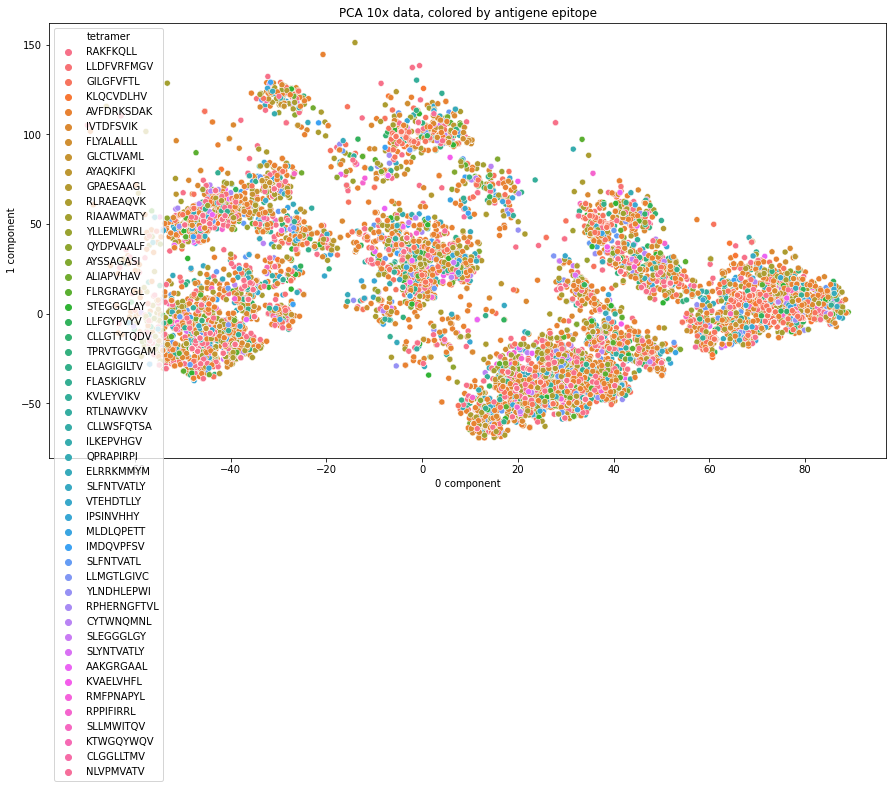

In [19]:
pc1 = 0
pc2 = 1
plt.figure(figsize=(15,8))
ax = sns.scatterplot(pc1, pc2, data=pca_df_data, hue='tetramer')
ax.set_title("PCA 10x data, colored by antigene epitope")
ax.set_xlabel(str(pc1)+" component")
ax.set_ylabel(str(pc2)+" component")

In [21]:
X_embedded = data_processing.tsne(pca_df,2,0,50)
tsne_df = pd.DataFrame(data = X_embedded, columns = ['DM1', 'DM2'])


tsne_df_data = tsne_df.copy()
#tsne_df_data['cdr3']=data_c_b_dist.index
tsne_df_data['barcode']=data_c_b_dist.index

tsne_df_data=tsne_df_data.merge(data_c[['barcode','tetramer','cdr3']], on='barcode')
tsne_df_data= tsne_df_data.groupby(['barcode']).first().reset_index()
tsne_df_data

,barcode,DM1,DM2,tetramer,cdr3
0,AAACCTGAGAAACCTA-30,-45.343693,-3.923413,RAKFKQLL,CASSFSGNTGELFF
1,AAACCTGAGAAGGGTA-9,-1.277696,44.858757,RAKFKQLL,CASSPHFQVDTGELFF
2,AAACCTGAGACACTAA-40,-37.641129,24.605511,LLDFVRFMGV,CASSPFWTDGNTIYF
3,AAACCTGAGACGCTTT-11,-45.577316,-2.991949,RAKFKQLL,CASSFSGNTGELFF
4,AAACCTGAGACTGGGT-33,79.623840,-14.230164,GILGFVFTL,CASSARSSYEQYF
...,...,...,...,...,...
41822,TTTGTCATCGTCACGG-40,-32.438213,54.879604,AAKGRGAAL,CASSLSRRGGYTF
41823,TTTGTCATCGTCTGAA-13,19.051332,14.023195,RAKFKQLL,CSVGSGDHGEQFF
41824,TTTGTCATCTCAAGTG-14,-19.145763,-23.103308,RAKFKQLL,CASSLRDGSEAFF
41825,TTTGTCATCTGCGTAA-36,-21.852688,38.429787,AVFDRKSDAK,CSDWEGGSTEAFF


/home/yuliajk/.conda-envs/python3/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/home/yuliajk/.conda-envs/python3/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


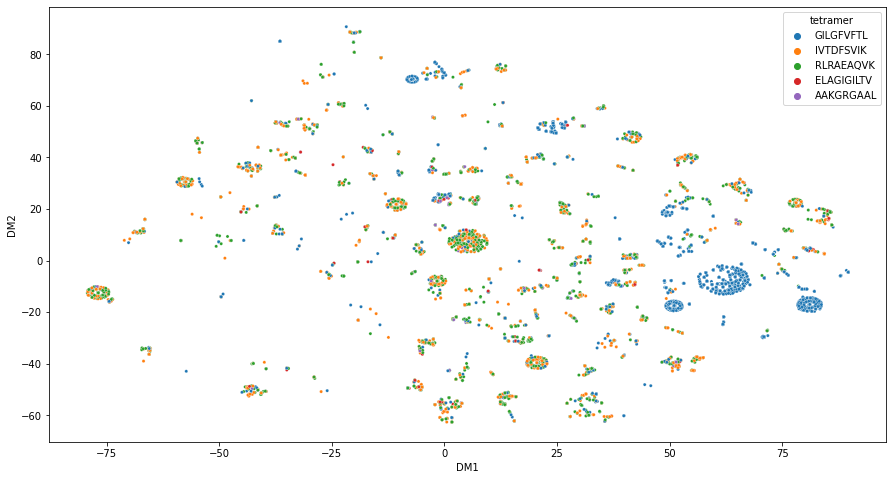

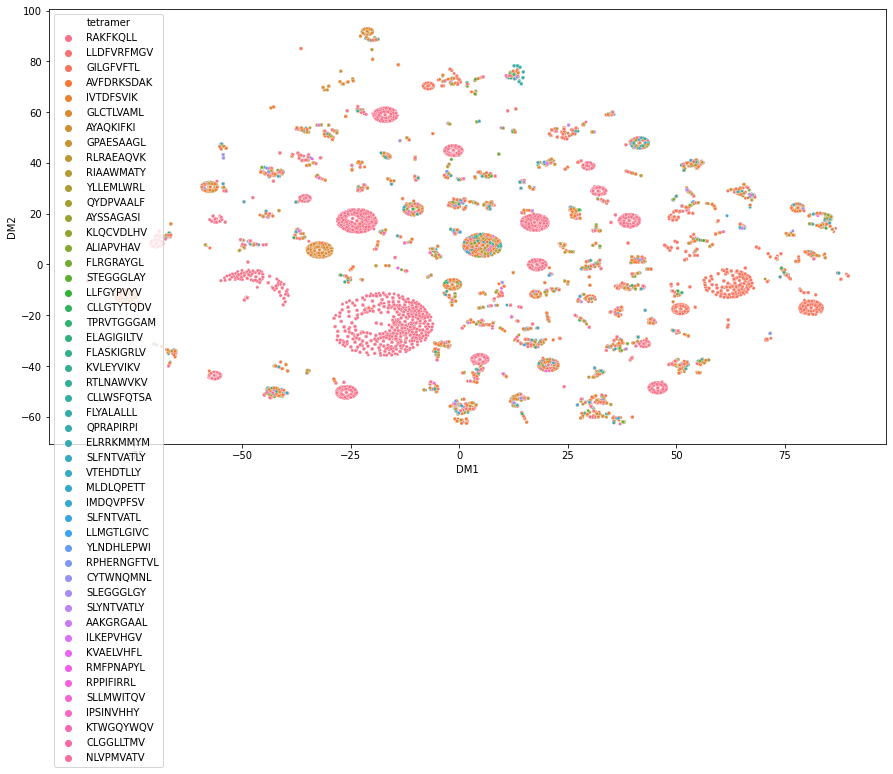

In [22]:
plt.figure(figsize=(15,8))
ax = sns.scatterplot('DM1', 'DM2', data=tsne_df_data[tsne_df_data['tetramer'].isin(['KLGGALQAK','AAKGRGAAL','GILGFVFTL','ELAGIGILTV','RLRAEAQVK','IVTDFSVIK'])], hue='tetramer',s=10)
#ax = sns.scatterplot('DM1', 'DM2', data=tsne_df,s=10)
#ax.text(x=0.5, y=1.1, s='TSNE of VDJdb 10x data after PCA, colored by cell.subset', fontsize=12, weight='bold', ha='center', va='bottom', transform=ax.transAxes)
#ax.text(x=0.5, y=1.05, s='TCRemb', fontsize=10, alpha=0.75, ha='center', va='bottom', transform=ax.transAxes)
#ax.set_title("TSNE of VDJdb 10x data after PCA, colored by j segment")

plt.figure(figsize=(15,8))
ax = sns.scatterplot('DM1', 'DM2', data=tsne_df_data, hue='tetramer',s=10)
#ax = sns.scatterplot('DM1', 'DM2', data=tsne_df,s=10)
#ax.text(x=0.5, y=1.1, s='TSNE of VDJdb 10x data after PCA, colored by cell.subset', fontsize=12, weight='bold', ha='center', va='bottom', transform=ax.transAxes)
#ax.text(x=0.5, y=1.05, s='TCRemb', fontsize=10, alpha=0.75, ha='center', va='bottom', transform=ax.transAxes)
#ax.set_title("TSNE of VDJdb 10x data after PCA, colored by j segment")

## Clustering

In [23]:
kmeans = KMeans(n_clusters=80, random_state=0).fit(pca_df)

In [24]:
clusters = pd.DataFrame(kmeans.labels_, columns= ['cluster'])
df_kmeans = pd.concat([tsne_df_data, clusters], axis = 1)
df_kmeans

,barcode,DM1,DM2,tetramer,cdr3,cluster
0,AAACCTGAGAAACCTA-30,-45.343693,-3.923413,RAKFKQLL,CASSFSGNTGELFF,1
1,AAACCTGAGAAGGGTA-9,-1.277696,44.858757,RAKFKQLL,CASSPHFQVDTGELFF,11
2,AAACCTGAGACACTAA-40,-37.641129,24.605511,LLDFVRFMGV,CASSPFWTDGNTIYF,16
3,AAACCTGAGACGCTTT-11,-45.577316,-2.991949,RAKFKQLL,CASSFSGNTGELFF,1
4,AAACCTGAGACTGGGT-33,79.623840,-14.230164,GILGFVFTL,CASSARSSYEQYF,5
...,...,...,...,...,...,...
41822,TTTGTCATCGTCACGG-40,-32.438213,54.879604,AAKGRGAAL,CASSLSRRGGYTF,38
41823,TTTGTCATCGTCTGAA-13,19.051332,14.023195,RAKFKQLL,CSVGSGDHGEQFF,34
41824,TTTGTCATCTCAAGTG-14,-19.145763,-23.103308,RAKFKQLL,CASSLRDGSEAFF,6
41825,TTTGTCATCTGCGTAA-36,-21.852688,38.429787,AVFDRKSDAK,CSDWEGGSTEAFF,44


/home/yuliajk/.conda-envs/python3/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/home/yuliajk/.conda-envs/python3/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


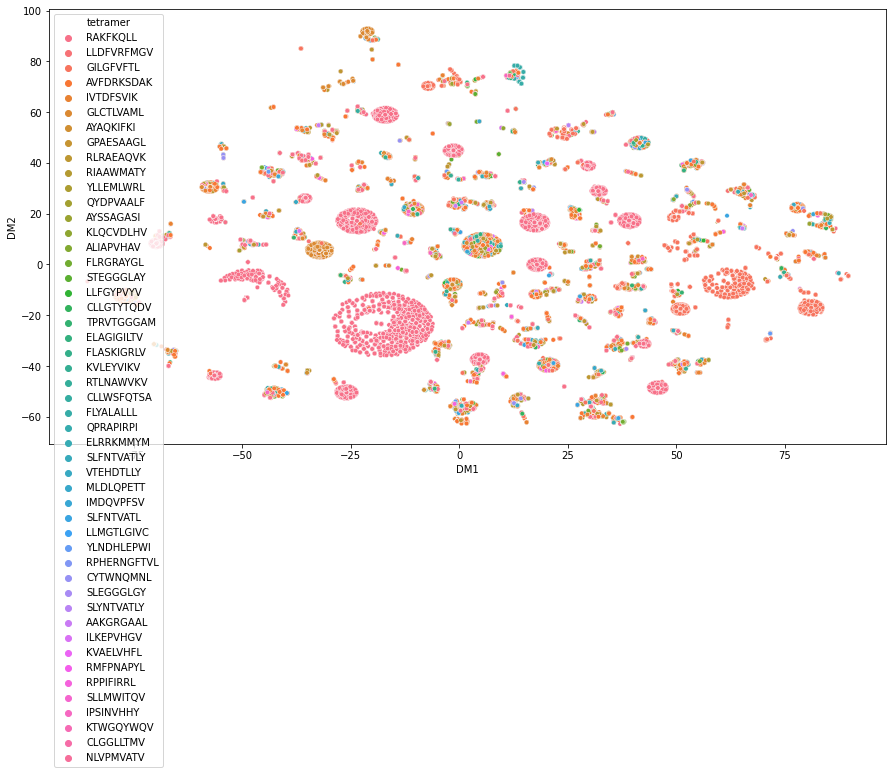

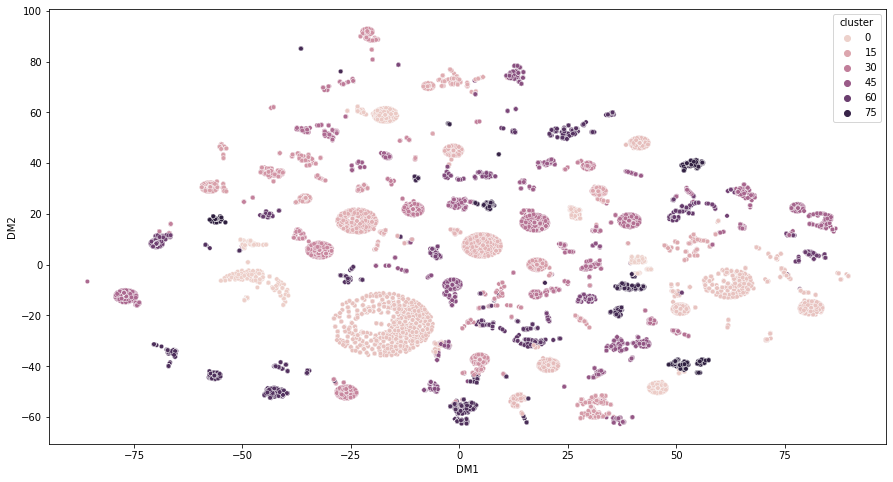

In [25]:
plt.figure(figsize=(15,8))
ax = sns.scatterplot('DM1', 'DM2', data=df_kmeans, hue='tetramer',s=20)
#ax = sns.scatterplot('DM1', 'DM2', data=tsne_df,s=10)
#ax.text(x=0.5, y=1.1, s='TSNE of VDJdb 10x data after PCA, colored by cell.subset', fontsize=12, weight='bold', ha='center', va='bottom', transform=ax.transAxes)
#ax.text(x=0.5, y=1.05, s='TCRemb', fontsize=10, alpha=0.75, ha='center', va='bottom', transform=ax.transAxes)
#ax.set_title("TSNE of VDJdb 10x data after PCA, colored by j segment")
plt.figure(figsize=(15,8))
ax = sns.scatterplot('DM1', 'DM2', data=df_kmeans, hue='cluster',s=20)

/home/yuliajk/.conda-envs/python3/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


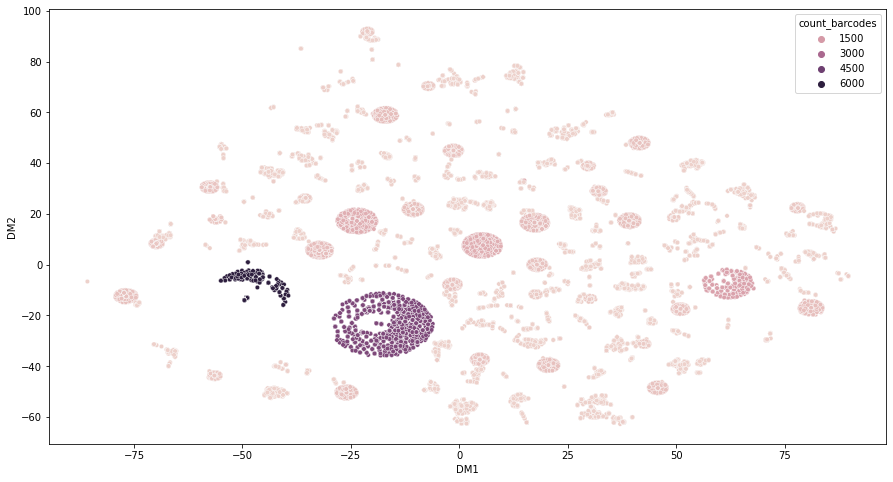

In [26]:
df_kmeans['count_barcodes'] = df_kmeans.groupby('cdr3')['barcode'].transform("size")
plt.figure(figsize=(15,8))
ax = sns.scatterplot('DM1', 'DM2', data=df_kmeans, hue='count_barcodes',s=20)


In [27]:
#binominal test
binom_df = df_kmeans.copy()
binom_df['total_cluster'] = binom_df.groupby('cluster')['cluster'].transform('count')
binom_df['total_epi'] = binom_df.groupby('tetramer')['tetramer'].transform('count')
binom_df['count_mached'] = binom_df.groupby(['tetramer','cluster'])['tetramer'].transform('count')
binom_df['fraction_mached'] = binom_df['count_mached']/binom_df['total_cluster']
binom_df['fraction_mached_e'] = binom_df['total_epi']/len(binom_df.index)
binom_df['p_value'] = binom_df.apply(lambda row: stats.binom_test(row['count_mached'], n=row['total_cluster'], p=row['fraction_mached_e'], alternative='greater'),axis=1)
binom_df = binom_df[binom_df['fraction_mached']>binom_df['fraction_mached_e']]
binom_df_v = binom_df[['tetramer','cluster','total_cluster','total_epi','count_mached','fraction_mached','fraction_mached_e','p_value']].drop_duplicates().sort_values('p_value')
#binom_df_v.to_csv('data_scripts/emb_binom_df.txt',sep='\t', index = False)
binom_df_cluster = binom_df_v.copy()
binom_df_cluster = binom_df_cluster.sort_values(['fraction_mached'],ascending=False)
binom_df_cluster = binom_df_cluster.drop_duplicates('cluster',keep='first')
binom_df_cluster

,tetramer,cluster,total_cluster,total_epi,count_mached,fraction_mached,fraction_mached_e,p_value
0,RAKFKQLL,1,6224,20366,6143,0.986986,0.486910,0.000000e+00
40,RAKFKQLL,79,269,20366,264,0.981413,0.486910,1.255077e-74
19,RAKFKQLL,6,4221,20366,4122,0.976546,0.486910,0.000000e+00
15,RAKFKQLL,27,464,20366,449,0.967672,0.486910,1.298346e-117
238,RAKFKQLL,2,390,20366,377,0.966667,0.486910,1.647869e-98
...,...,...,...,...,...,...,...,...
10702,AVFDRKSDAK,73,100,4549,17,0.170000,0.108758,4.162084e-02
492,GLCTLVAML,44,307,1586,45,0.146580,0.037918,1.346013e-14
1839,AVFDRKSDAK,55,143,4549,20,0.139860,0.108758,1.449634e-01
2532,AVFDRKSDAK,7,391,4549,52,0.132992,0.108758,7.535548e-02


In [28]:
binom_df_cluster.head(20)

,tetramer,cluster,total_cluster,total_epi,count_mached,fraction_mached,fraction_mached_e,p_value
0,RAKFKQLL,1,6224,20366,6143,0.986986,0.486910,0.000000e+00
40,RAKFKQLL,79,269,20366,264,0.981413,0.486910,1.255077e-74
19,RAKFKQLL,6,4221,20366,4122,0.976546,0.486910,0.000000e+00
15,RAKFKQLL,27,464,20366,449,0.967672,0.486910,1.298346e-117
238,RAKFKQLL,2,390,20366,377,0.966667,0.486910,1.647869e-98
4,GILGFVFTL,5,2972,5371,2863,0.963324,0.128410,0.000000e+00
1,RAKFKQLL,11,383,20366,365,0.953003,0.486910,1.730256e-89
112,RAKFKQLL,34,638,20366,607,0.951411,0.486910,1.075891e-146
101,RAKFKQLL,36,583,20366,549,0.941681,0.486910,5.232441e-127
10,RAKFKQLL,15,346,20366,321,0.927746,0.486910,2.288616e-70


## Classification

In [29]:
tetramers = list(tsne_df_data['tetramer'].drop_duplicates())
y_train, y_test,X_train, X_test,  = train_test_split(tsne_df_data['tetramer'],tsne_df,test_size=0.5)
y_test_curv = label_binarize(y_test, classes=tetramers)

### KNN

In [30]:
# Perform KNN
n_neighbors = 10
knn = neighbors.KNeighborsClassifier(n_neighbors)
knn.fit(X_train, y_train)

pred = knn.predict(X_test)
y_pred_curv = label_binarize(pred, classes=tetramers)

In [31]:
n_classes = y_test_curv.shape[1]
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_curv[:,i],y_pred_curv[:,i])
    roc_auc[i] = auc(fpr[i], tpr[i])
pd.DataFrame(roc_auc.values(),tetramers, columns = ['roc_auc']).sort_values('roc_auc',ascending=False).head(10)

,roc_auc
GLCTLVAML,0.933600
RAKFKQLL,0.929420
GILGFVFTL,0.918789
FLRGRAYGL,0.777464
FLYALALLL,0.776810
AVFDRKSDAK,0.722881
LLFGYPVYV,0.545621
RLRAEAQVK,0.540304
IVTDFSVIK,0.538984
AYAQKIFKI,0.509019


### SVM

In [32]:
from sklearn import svm

svc = svm.SVC()
svc.fit(X_train, y_train)
svc_pred = svc.predict(X_test)
y_pred_curv_svc = label_binarize(svc_pred, classes=tetramers)

In [33]:
n_classes = y_test_curv.shape[1]
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_curv[:,i],y_pred_curv_svc[:,i])
    roc_auc[i] = auc(fpr[i], tpr[i])
pd.DataFrame(roc_auc.values(),tetramers, columns = ['roc_auc']).sort_values('roc_auc',ascending=False).head(10)

,roc_auc
GILGFVFTL,0.849297
FLYALALLL,0.804552
RAKFKQLL,0.710517
FLRGRAYGL,0.700549
GLCTLVAML,0.627068
AVFDRKSDAK,0.570520
VTEHDTLLY,0.500000
MLDLQPETT,0.500000
IMDQVPFSV,0.500000
SLFNTVATL,0.500000


/home/yuliajk/.conda-envs/python3/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


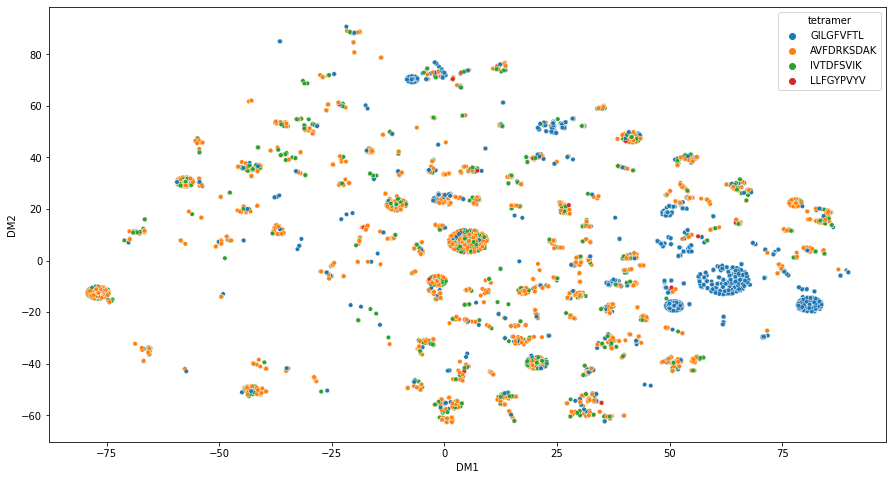

In [34]:
plt.figure(figsize=(15,8))
ax = sns.scatterplot('DM1', 'DM2', data=df_kmeans[df_kmeans['tetramer'].isin(['LLFGYPVYV','GILGFVFTL','IVTDFSVIK','AVFDRKSDAK'])], hue='tetramer',s=20)                   
